In [6]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
def data_transf_underlying(df_underlying_asset):
 df_underlying_transformed = df_underlying_asset[['Date ', 'close ']]
 df_underlying_transformed['Date '] = pd.to_datetime(df_underlying_transformed['Date '])
 df_underlying_transformed = df_underlying_transformed.applymap(lambda x: float(x.replace(',', '')) if isinstance(x, str) else x)
 return df_underlying_transformed

def simulate_stock_paths(S0, mu, sigma, T, M, I):
    dt = T / M
    paths = np.zeros((M + 1, I))
    paths[0] = S0
    for t in range(1, M + 1):
        z = np.random.normal(scale=sigma,size=I)
        paths[t] = paths[t - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
    return paths

def monte_european(S,K,T,r,vol,I,type):
    priced=[]
    for i in range(I):
        price=S*np.exp((r-(0.5*vol**2))*T+(vol*np.sqrt(T)*np.random.normal(0,1)))
        if type=='call':
            priced.append(max(0,K-price))
        else:
            priced.append(max(0,price-K))
    return np.exp(-r*T)*np.mean(priced)


def monte_american(S,K,T,r,vol,I,N,type):
    prices=[]
    for i in range(N):
        prices.append(monte_european(S,K,(i+1)*T/N,r,vol,I,type))
    return max(prices)

In [8]:
underlying_data = pd.read_csv(r"C:\Users\Admin\OneDrive\Desktop\Finsearch\Dataset\reliance_underlying_2023.csv")
underlying_data = data_transf_underlying(underlying_data)
close_price = underlying_data['close ']
close_price_rev = close_price[::-1]
S0 = 2318.15
T = 60/365
M = 60
I = 10000
r = 0.07
K = 2400
sigma = 0.189
mu=0.5*(sigma**2)+(1/T)*np.log(2605.55/2318.19)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14380\1682323567.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_underlying_transformed['Date '] = pd.to_datetime(df_underlying_transformed['Date '])
C:\Users\Admin\AppData\Local\Temp\ipykernel_14380\1682323567.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_underlying_transformed = df_underlying_transformed.applymap(lambda x: float(x.replace(',', '')) if isinstance(x, str) else x)


In [9]:
option_price = monte_european(S0,K,T,r,sigma,I,'call')

In [10]:
print(option_price)

102.03248921468278


In [12]:
simulation = simulate_stock_paths(S0, mu, sigma, T, M, I)

C:\Users\Admin\AppData\Local\Temp\ipykernel_14380\1682323567.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_underlying_transformed['Date '] = pd.to_datetime(df_underlying_transformed['Date '])
C:\Users\Admin\AppData\Local\Temp\ipykernel_14380\1682323567.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_underlying_transformed = df_underlying_transformed.applymap(lambda x: float(x.replace(',', '')) if isinstance(x, str) else x)


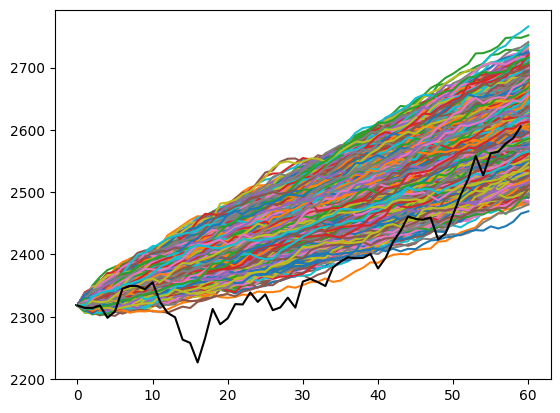

In [24]:
for i in range(I):
    plt.plot(np.arange(M + 1), simulation[:,i])

close_price = data_transf_underlying(pd.read_csv('reliance_underlying_2023.csv'))['close ']
plt.plot(np.arange(60), close_price[59::-1], color = 'black')